<a href="https://colab.research.google.com/github/hannah1412/Audio-and-Image-Processing/blob/main/NDVI_sentinel_2_data_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import ee
import geemap
import xarray as xr
!pip install xee
import xee

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 20.2 MB/s eta 0:00:00


In [3]:
ee.Authenticate()

In [4]:
ee.Initialize(project='elite-elevator-432015-d8')

In [5]:
map = geemap.Map(basemap='SATELLITE')


In [6]:
import geopandas as gpd

try:
  roi = gpd.read_file('/content/data/FOIs.shp')
  print("Shapefile loaded successfully.")
  print(roi.head())
except Exception as e:
  print(f"Error loading shapefile: {e}")

Error loading shapefile: /content/data/FOIs.shp: No such file or directory


In [10]:
try:
    ee_roi = geemap.geopandas_to_ee(roi)
    print("Shapefile converted to Earth Engine FeatureCollection.")
    print(ee_roi.first().getInfo())
except NameError:
    print("The 'roi' variable was not found. Please run the previous cell to load the shapefile.")
except Exception as e:
    print(f"Error converting to Earth Engine FeatureCollection: {e}")

The 'roi' variable was not found. Please run the previous cell to load the shapefile.


In [11]:
try:
    map.add_layer(ee_roi, {}, 'Region of Interest')
    map
except NameError:
    print("The 'ee_roi' variable was not found. Please run the previous cell to convert the shapefile to an Earth Engine FeatureCollection.")
except Exception as e:
    print(f"Error adding ROI to map: {e}")

The 'ee_roi' variable was not found. Please run the previous cell to convert the shapefile to an Earth Engine FeatureCollection.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [9]:
map.addLayer(ee_roi, {}, 'Region of interest')
map

NameError: name 'ee_roi' is not defined

In [16]:
start_date = '2022-04-01'
end_date ='2022-10-01'

In [41]:
def cloud_masking(img):
  qa = img.select('probability')
  cloud_masking = qa.lt(60)
  ms = img.select('B.*').divide(10000)
  ndvi = ms.normalizedDifference(['B8', 'B4']).rename('NDVI')
  return ndvi.updateMask(cloud_masking).copyProperties(img, ['system:time_start'])

In [42]:
sentinel2 = (
    ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED').linkCollection(
        ee.ImageCollection('COPERNICUS/S2_CLOUD_PROBABILITY'), 'probability'
    )
    .filterBounds(ee_roi)
    .filterDate(start_date, end_date)
    .map(cloud_masking)
)
sentinel2

In [1]:
# Merge the features in the FeatureCollection into a single geometry
ee_roi_geometry = ee_roi.geometry()

ds = xr.open_dataset(
    sentinel2,
    engine = 'ee',
    crs = 'EPSG:4326',
    geometry = ee_roi_geometry,
    scale = 0.002
)

NameError: name 'ee_roi' is not defined

In [50]:
ds

<xarray.Dataset> Size: 227kB
Dimensions:  (time: 73, lon: 43, lat: 18)
Coordinates:
  * time     (time) datetime64[ns] 584B 2022-04-02T11:35:36.633000 ... 2022-0...
  * lon      (lon) float64 344B -2.814 -2.814 -2.813 ... -2.802 -2.802 -2.801
  * lat      (lat) float64 144B 56.73 56.73 56.73 56.73 ... 56.73 56.73 56.73
Data variables:
    NDVI     (time, lon, lat) float32 226kB ...
Attributes: (12/18)
    date_range:             [1490659200000, 1647907200000]
    description:            <p>Sentinel-2 is a wide-swath, high-resolution, m...
    keywords:               ['copernicus', 'esa', 'eu', 'msi', 'reflectance',...
    period:                 0
    product_tags:           ['msi', 'sr', 'reflectance']
    provider:               European Union/ESA/Copernicus
    ...                     ...
    type_name:              ImageCollection
    visualization_0_bands:  B4,B3,B2
    visualization_0_max:    3000.0
    visualization_0_min:    0.0
    visualization_0_name:   RGB
    crs:                    EPSG:4326

In [51]:
ds = ds.sortby('time') *1
ds


<xarray.Dataset> Size: 227kB
Dimensions:  (time: 73, lon: 43, lat: 18)
Coordinates:
  * time     (time) datetime64[ns] 584B 2022-04-02T11:35:36.633000 ... 2022-0...
  * lon      (lon) float64 344B -2.814 -2.814 -2.813 ... -2.802 -2.802 -2.801
  * lat      (lat) float64 144B 56.73 56.73 56.73 56.73 ... 56.73 56.73 56.73
Data variables:
    NDVI     (time, lon, lat) float32 226kB nan nan nan nan ... nan nan nan nan
Attributes: (12/18)
    date_range:             [1490659200000, 1647907200000]
    description:            <p>Sentinel-2 is a wide-swath, high-resolution, m...
    keywords:               ['copernicus', 'esa', 'eu', 'msi', 'reflectance',...
    period:                 0
    product_tags:           ['msi', 'sr', 'reflectance']
    provider:               European Union/ESA/Copernicus
    ...                     ...
    type_name:              ImageCollection
    visualization_0_bands:  B4,B3,B2
    visualization_0_max:    3000.0
    visualization_0_min:    0.0
    visualization_0_name:   RGB
    crs:                    EPSG:4326

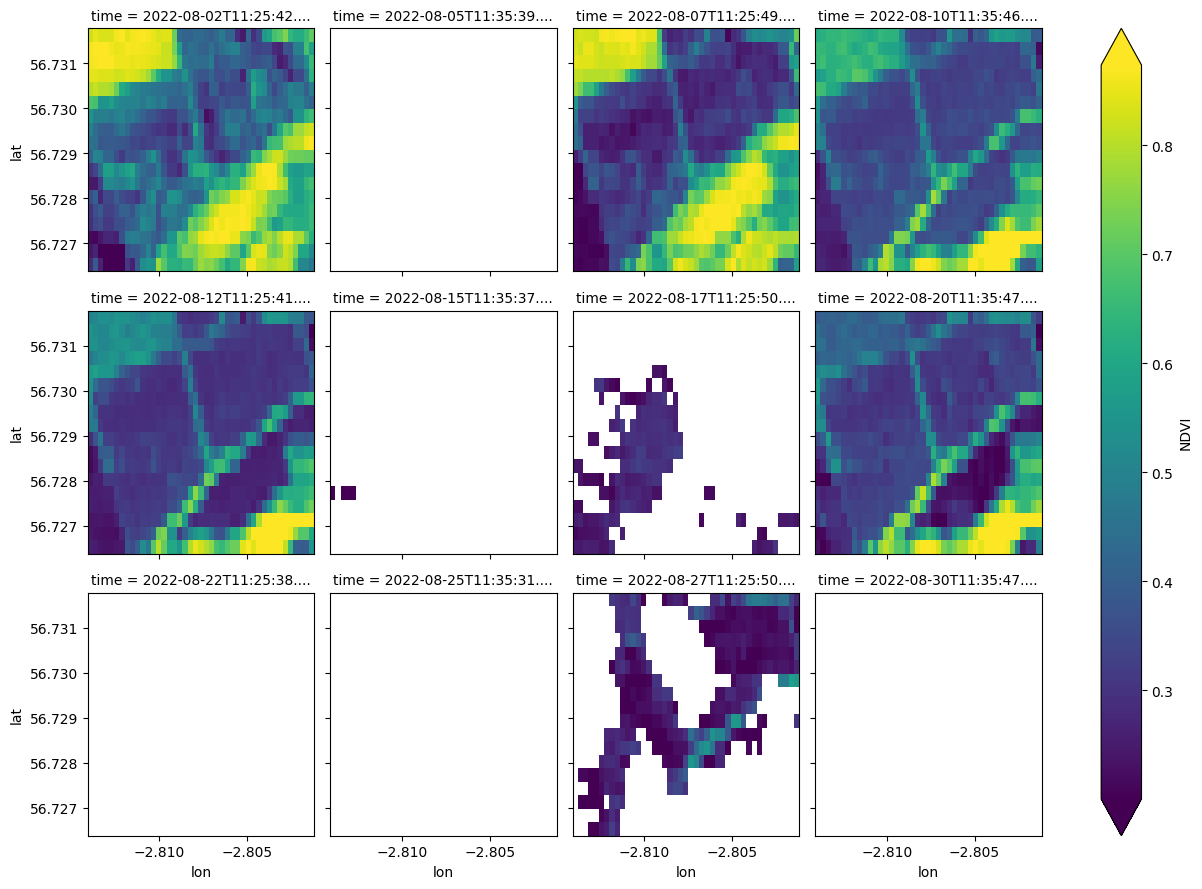

In [52]:

# Display ndvi in a chosen month
ds.sel(time = ds.time.dt.month == 8).NDVI.plot(
    x = 'lon',
    y = 'lat',
    col = 'time',
    col_wrap =4,
    robust = True,
)

In [62]:
# Weekly dataset
ds_weekly = ds.resample(time = '5D').median('time')
ds_weekly

<xarray.Dataset> Size: 115kB
Dimensions:  (time: 37, lon: 43, lat: 18)
Coordinates:
  * time     (time) datetime64[ns] 296B 2022-04-02 2022-04-07 ... 2022-09-29
  * lon      (lon) float64 344B -2.814 -2.814 -2.813 ... -2.802 -2.802 -2.801
  * lat      (lat) float64 144B 56.73 56.73 56.73 56.73 ... 56.73 56.73 56.73
Data variables:
    NDVI     (time, lon, lat) float32 115kB nan nan nan nan ... nan nan nan nan
Attributes: (12/18)
    date_range:             [1490659200000, 1647907200000]
    description:            <p>Sentinel-2 is a wide-swath, high-resolution, m...
    keywords:               ['copernicus', 'esa', 'eu', 'msi', 'reflectance',...
    period:                 0
    product_tags:           ['msi', 'sr', 'reflectance']
    provider:               European Union/ESA/Copernicus
    ...                     ...
    type_name:              ImageCollection
    visualization_0_bands:  B4,B3,B2
    visualization_0_max:    3000.0
    visualization_0_min:    0.0
    visualization_0_name:   RGB
    crs:                    EPSG:4326

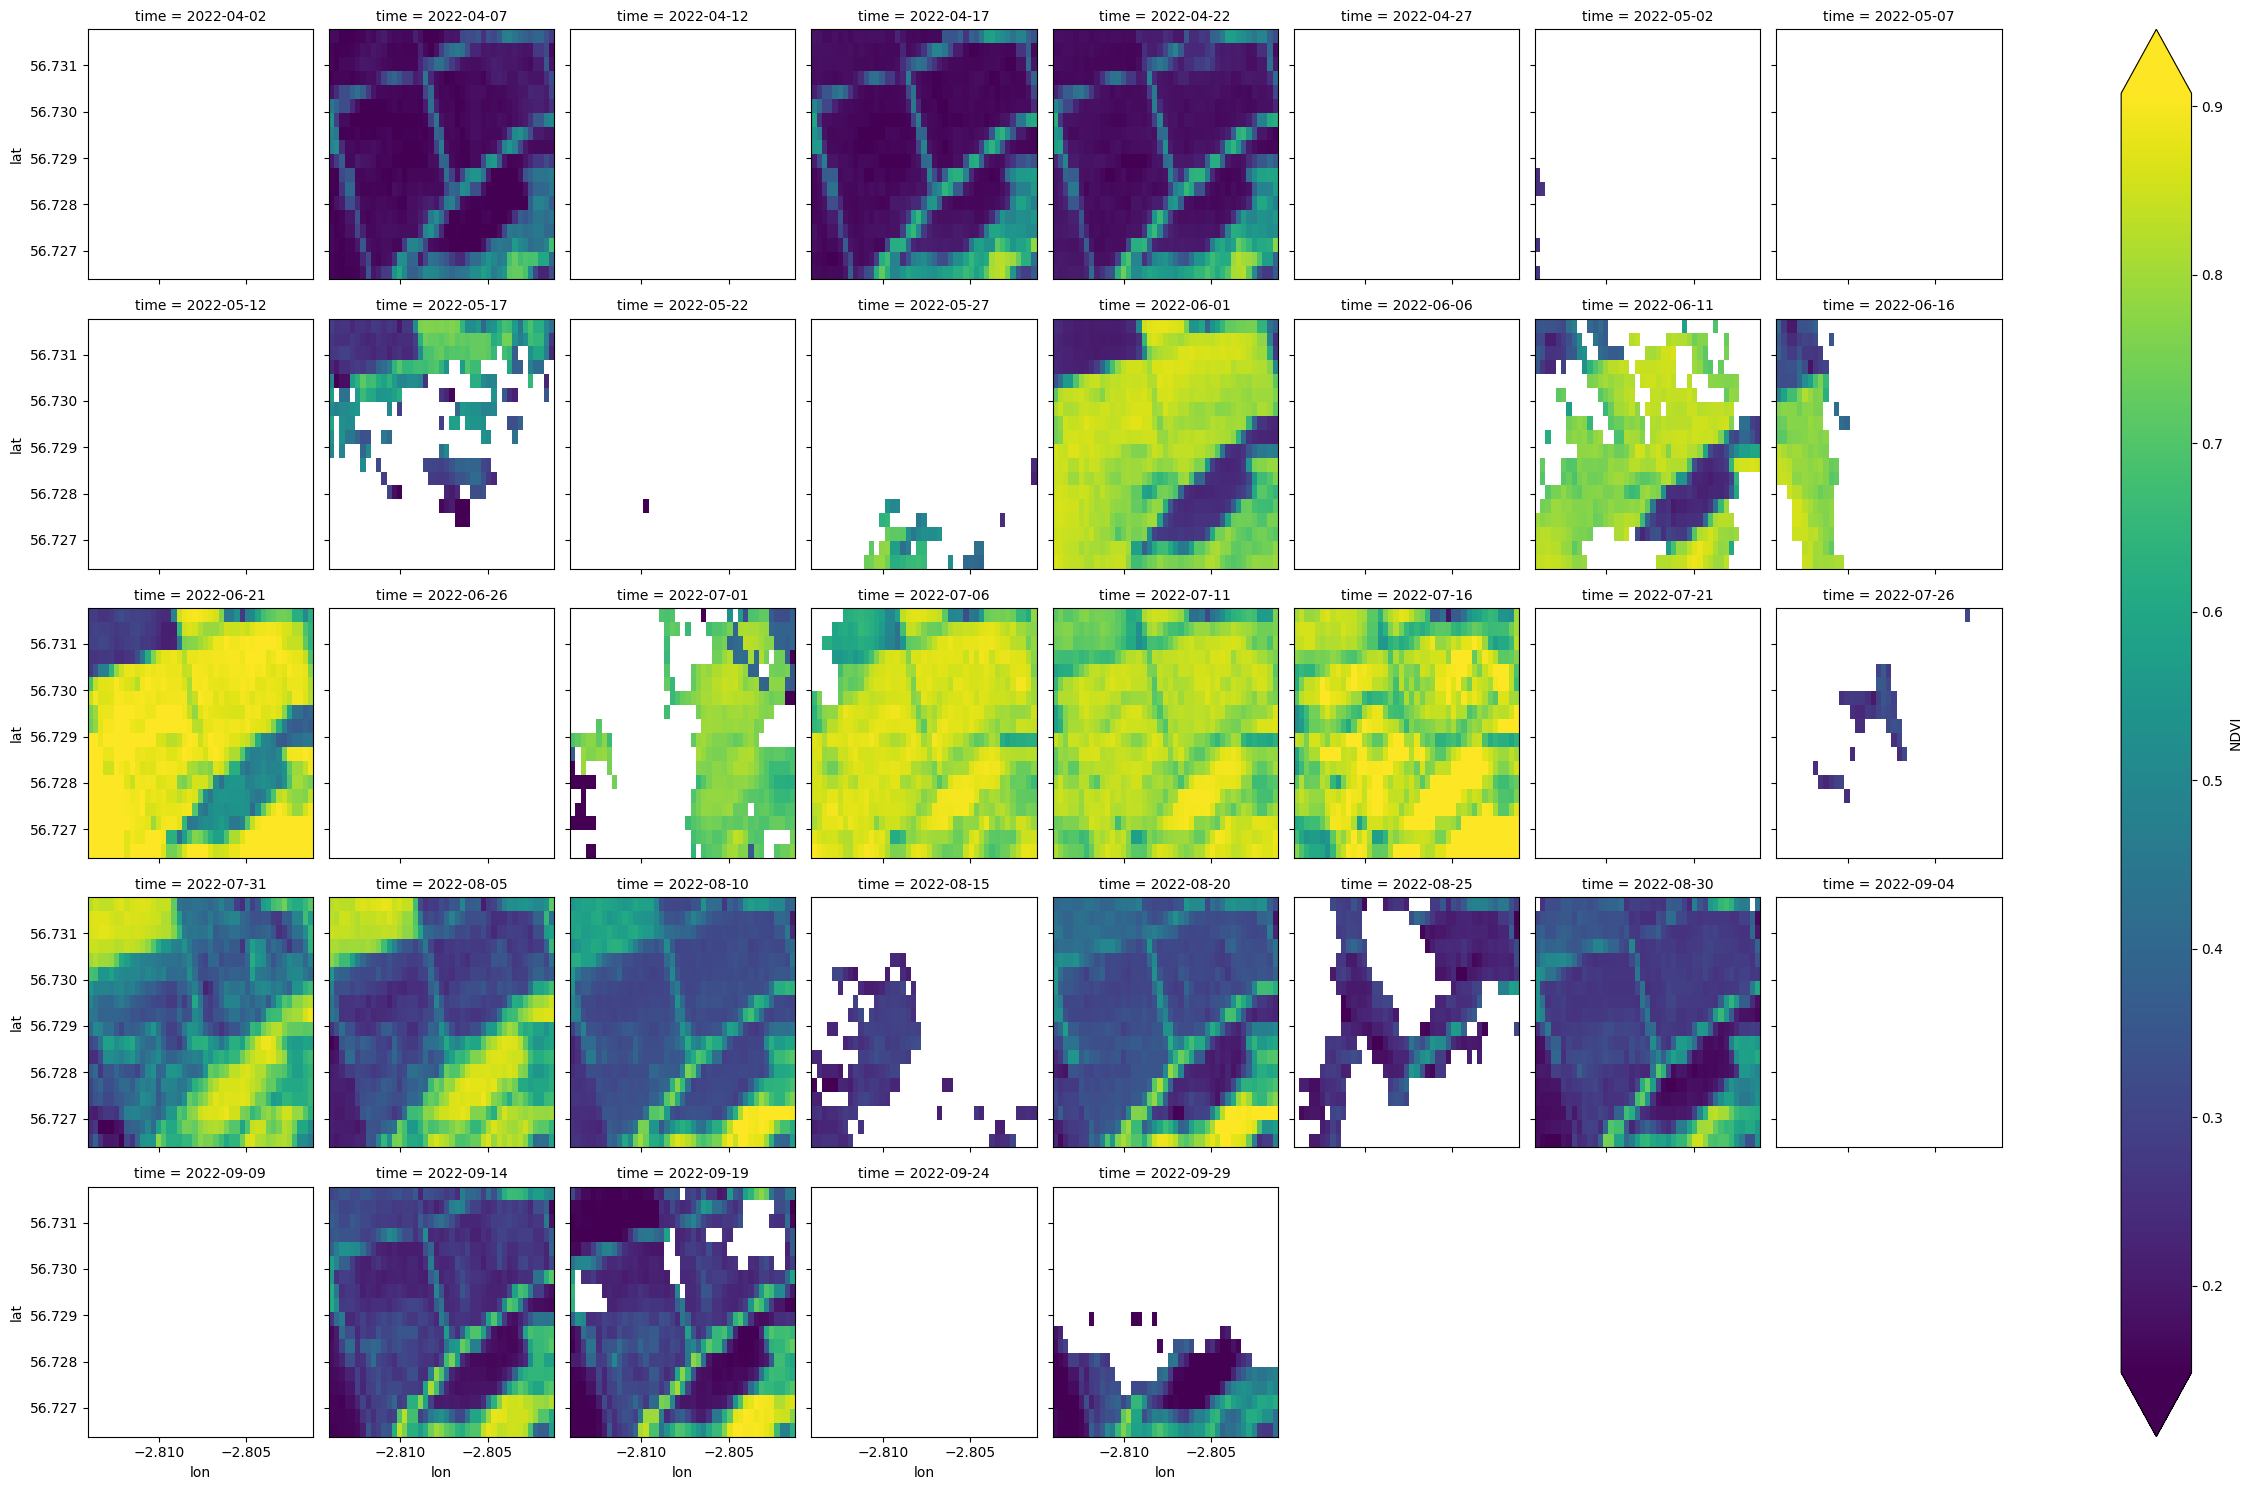

In [63]:
ds_weekly.NDVI.plot(
    x = 'lon',
    y = 'lat',
    col = 'time',
    col_wrap =8,

    robust = True,
)

In [66]:
ds_rol = ds_weekly.rolling(time = 10, min_periods= 1, center = True).mean('time')
ds_rol

<xarray.Dataset> Size: 115kB
Dimensions:  (lon: 43, lat: 18, time: 37)
Coordinates:
  * lon      (lon) float64 344B -2.814 -2.814 -2.813 ... -2.802 -2.802 -2.801
  * lat      (lat) float64 144B 56.73 56.73 56.73 56.73 ... 56.73 56.73 56.73
  * time     (time) datetime64[ns] 296B 2022-04-02 2022-04-07 ... 2022-09-29
Data variables:
    NDVI     (time, lon, lat) float32 115kB 0.1775 0.1729 0.1766 ... 0.15 0.4614
Attributes: (12/18)
    date_range:             [1490659200000, 1647907200000]
    description:            <p>Sentinel-2 is a wide-swath, high-resolution, m...
    keywords:               ['copernicus', 'esa', 'eu', 'msi', 'reflectance',...
    period:                 0
    product_tags:           ['msi', 'sr', 'reflectance']
    provider:               European Union/ESA/Copernicus
    ...                     ...
    type_name:              ImageCollection
    visualization_0_bands:  B4,B3,B2
    visualization_0_max:    3000.0
    visualization_0_min:    0.0
    visualization_0_name:   RGB
    crs:                    EPSG:4326

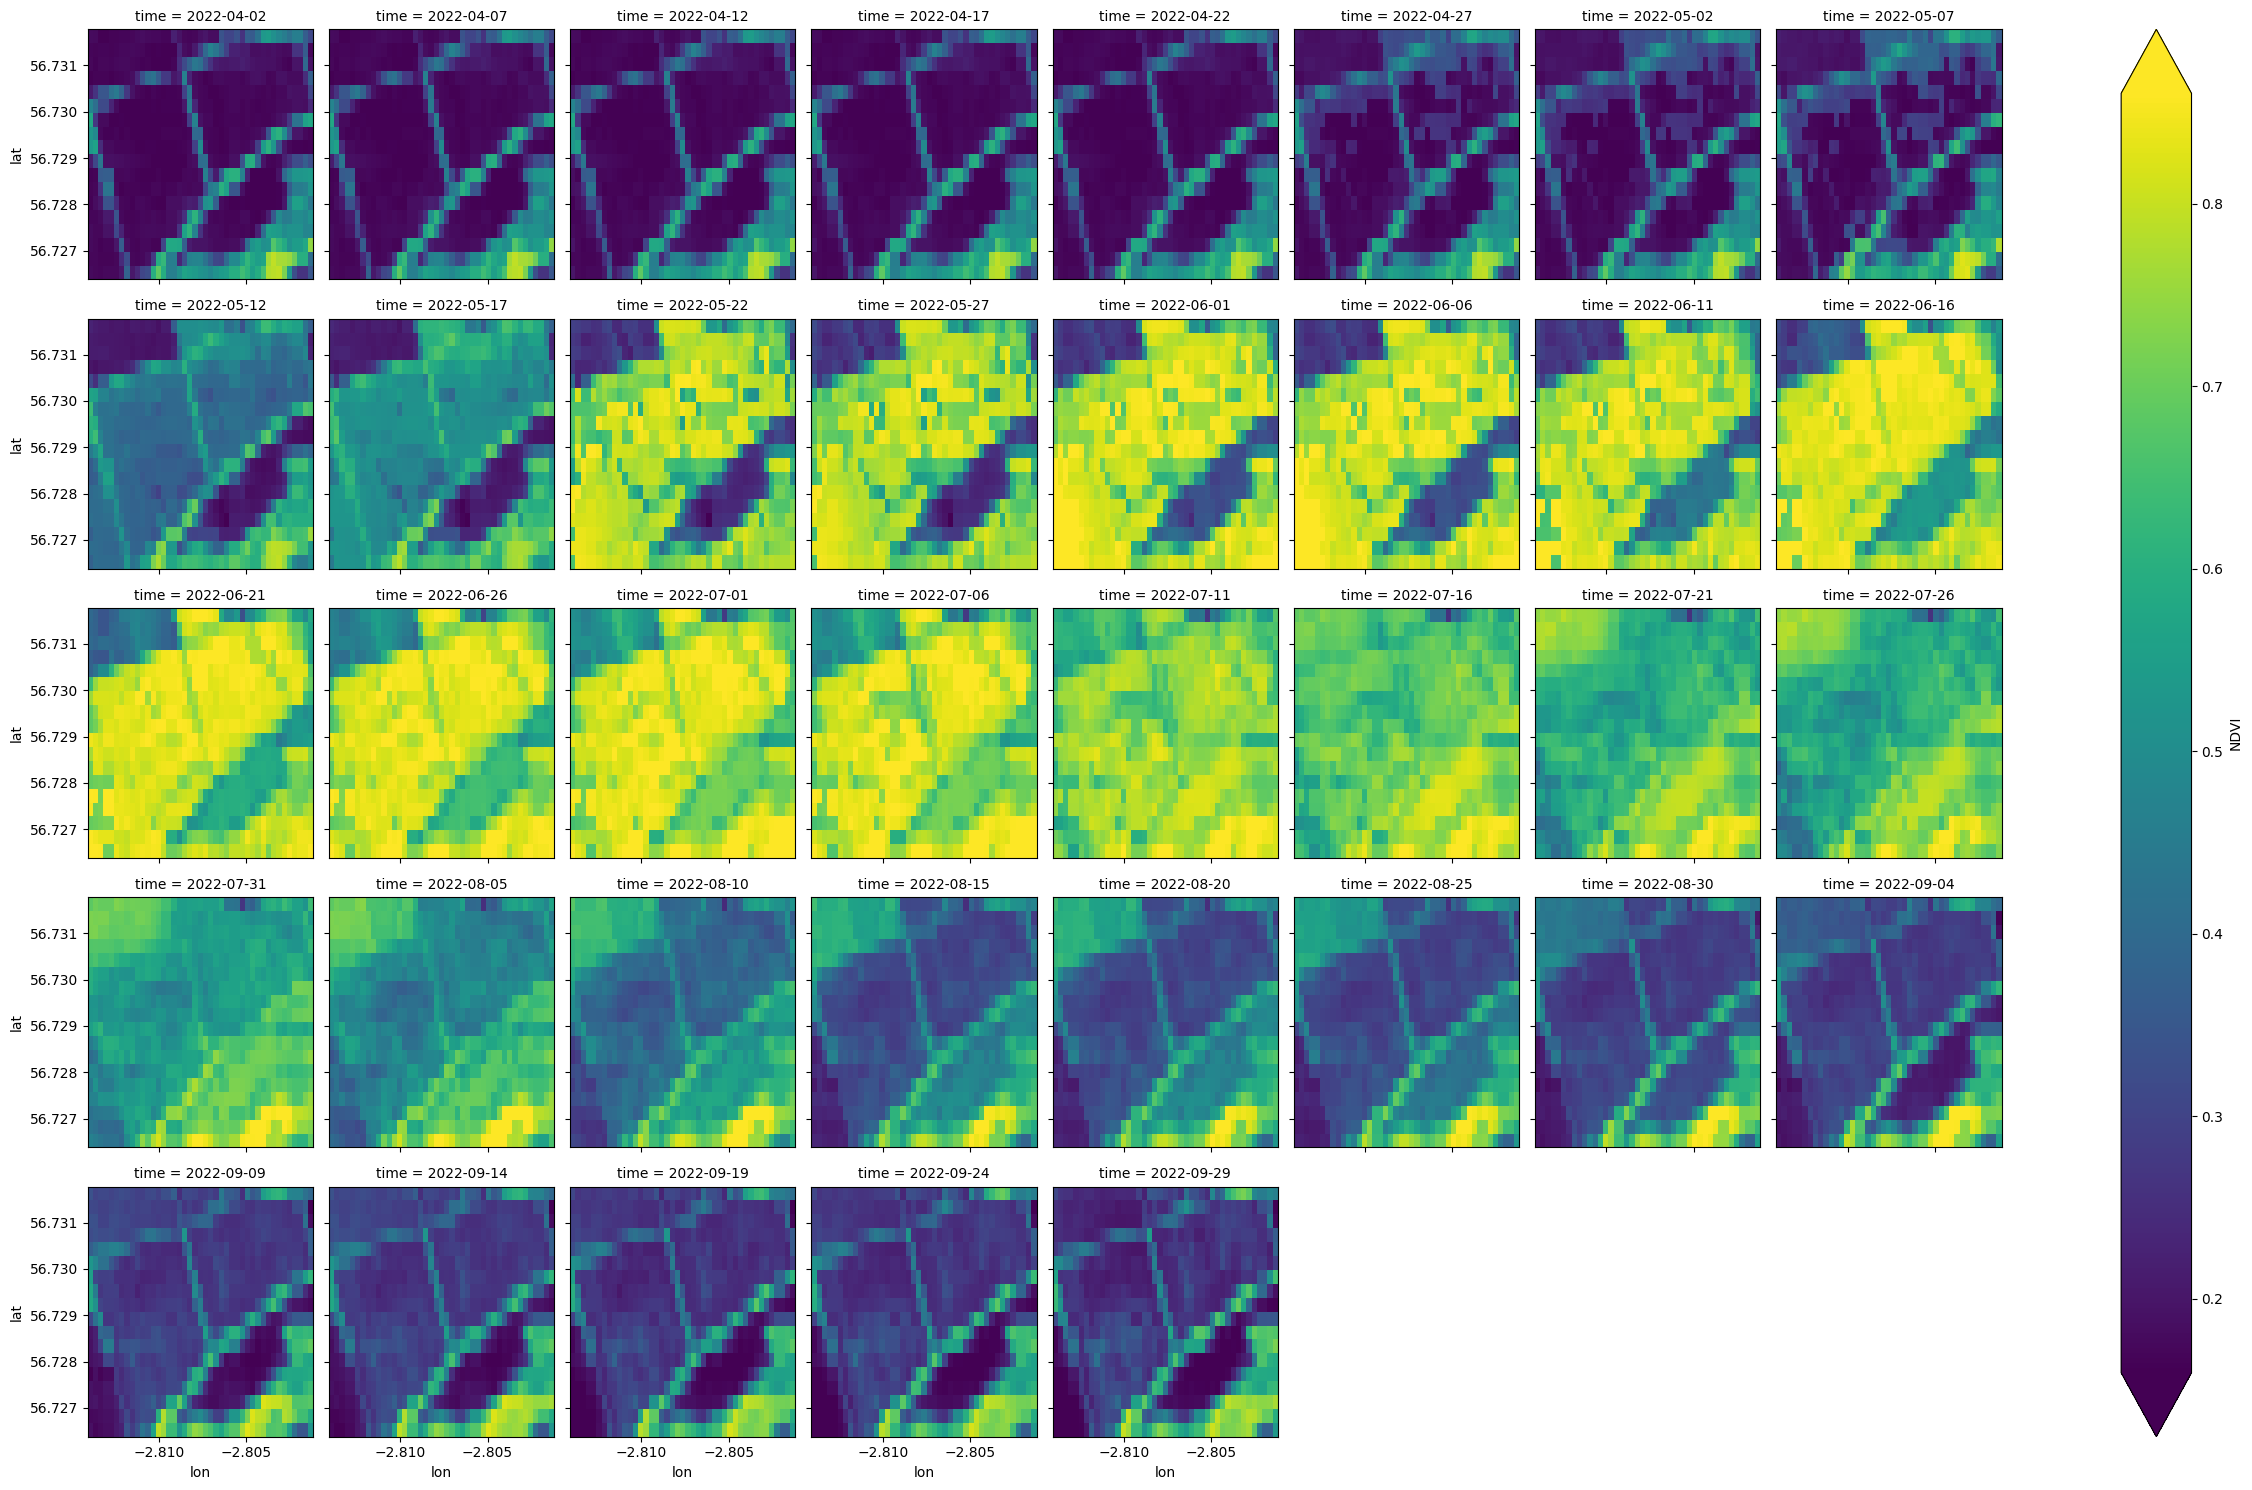

In [67]:
ds_rol.NDVI.plot(
    x = 'lon',
    y = 'lat',
    col = 'time',
    col_wrap =8,

    robust = True,
)